Functions for 4.1

In [ ]:
import numpy as np

#4.1.1

def compute_observable_expectation(t, observable, overlap_coefficients, eigenvalues, eigenvectors):
    """
    Compute the time-dependent expectation value of an observable.
    
    Parameters:
    - t (float): Time at which to compute the expectation.
    - observable (np.ndarray): The observable matrix.
    - overlap_coefficients (np.ndarray): Coefficients of the initial state in the energy eigenbasis.
    - eigenvalues (np.ndarray): Array of eigenvalues from the Hamiltonian diagonalization.
    - eigenvectors (np.ndarray): Array of eigenvectors from the Hamiltonian diagonalization.
    
    Returns:
    - expectation (complex): The expectation value of the observable at time t.
    """
    # Calculate matrix elements in the eigenbasis
    matrix_element = eigenvectors.conj().T @ observable @ eigenvectors

    # Calculate phase differences using broadcasting
    phase = np.exp(-1j * (eigenvalues[:, None] - eigenvalues[None, :]) * t)

    # Reshape overlap coefficients for broadcasting
    overlap_coefficients = overlap_coefficients[:, None]

    # Calculate expectation value
    expectation = np.sum(overlap_coefficients.conj() * overlap_coefficients.T * phase * matrix_element)

    return expectation
    

def periodic_dense_hamiltonian(L, h_x, h_z, J=1):
    # Initialize Hamiltonian to zero matrix
    H = np.zeros((2 ** L, 2 ** L))

    # Define Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.identity(2)

    # add the tensor product helper function
    def tensor_product(matrices):
        """Calculate the tensor product of a list of matrices."""
        result = matrices[0]
        for matrix in matrices[1:]:
            result = np.kron(result, matrix)
        return result
    
    # Interaction term
    for i in range(L):  # Add periodic term at the end if periodic
        matrices = [I] * L  # Start with identity matrices
        matrices[i] = sigma_z  # Apply sigma_z at position i
        matrices[(i + 1) % L] = sigma_z  # Apply sigma_z at position (i+1) modulo L for periodic
        H += -J * tensor_product(matrices)

    # Transverse field term for x
    for i in range(L):
        matrices = [I] * L  # Start with identity matrices
        matrices[i] = sigma_x  # Apply sigma_x at position i
        H += -h_x * tensor_product(matrices)

    # Transverse field term for z
    for i in range(L):
        matrices = [I] * L
        matrices[i] = sigma_z
        H += -h_z * tensor_product(matrices)

    return H
        

#4.1.2

def compute_thermal_energy(beta, eigenvalues):
    """
    Compute the thermal energy of a system characterized by size L at inverse temperature beta.
    
    Parameters:
    - beta: Inverse temperature.
    - L: System size.
    
    Returns:
    - thermal_energy: The thermal energy of the system.
    """
    Z = sum(np.exp(-beta * eigenvalues))
    thermal_energy = np.sum(eigenvalues * np.exp(-beta * eigenvalues)) / Z
    return thermal_energy    

def compute_thermal_observable(beta, eigenvalues, eigenvectors, observable):
    """
    Compute the thermal expectation value of an observable.
    
    Parameters:
    - beta: Inverse temperature.
    - eigenvalues: Eigenvalues from the Hamiltonian diagonalization.
    - eigenvectors: Eigenvectors from the Hamiltonian diagonalization.
    - observable: The observable matrix.
    
    Returns:
    - thermal_observable: The thermal expectation value of the observable.
    """
    boltzmann_factors = np.exp(-beta * eigenvalues)
    observable_in_basis = eigenvectors.conj().T @ observable @ eigenvectors
    weighted_trace = np.sum(boltzmann_factors * np.diag(observable_in_basis))
    Z = np.sum(boltzmann_factors)
    thermal_observable = weighted_trace / Z
    return thermal_observable

def make_product_state(single_site, L):
    """
    Generate the product state for a system of size L.
    
    Parameters:
    - single_site: The state of a single site.
    - L: The size of the system.
    
    Returns:
    - product_state: The product state of the system.
    """
    product_state = single_site.copy()
    for _ in range(1, L):
        product_state = np.kron(product_state, single_site)
    return product_state
    
#4.1.3
def time_dependent_state(t, overlap_coefficients, eigenvalues, eigenvectors):
    """Computes the time-dependent state |ψ(t)>."""
    return np.sum(np.exp(-1j * eigenvalues * t) * overlap_coefficients * eigenvectors, axis=1)


4.1.1: Time dependent expectation values

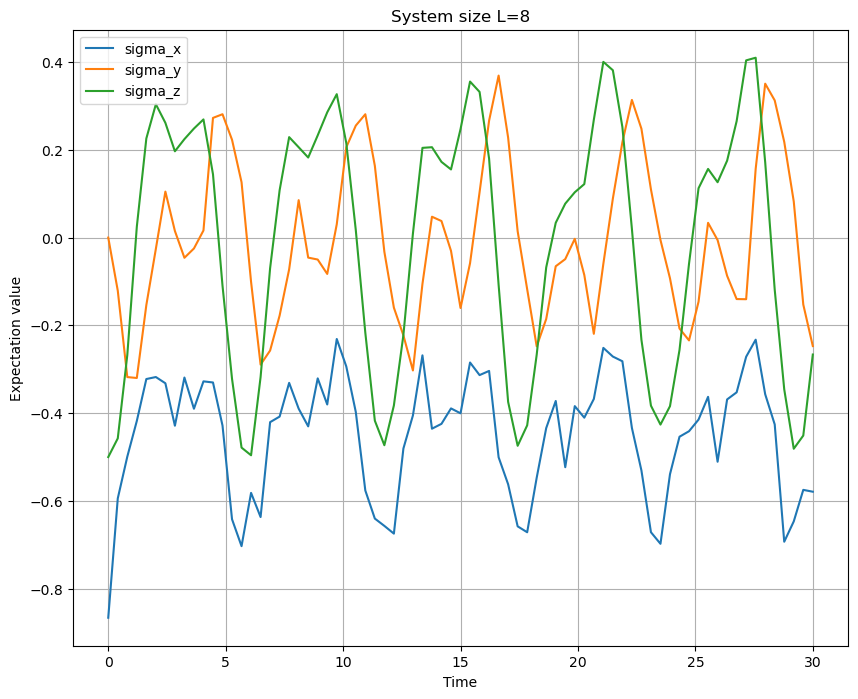

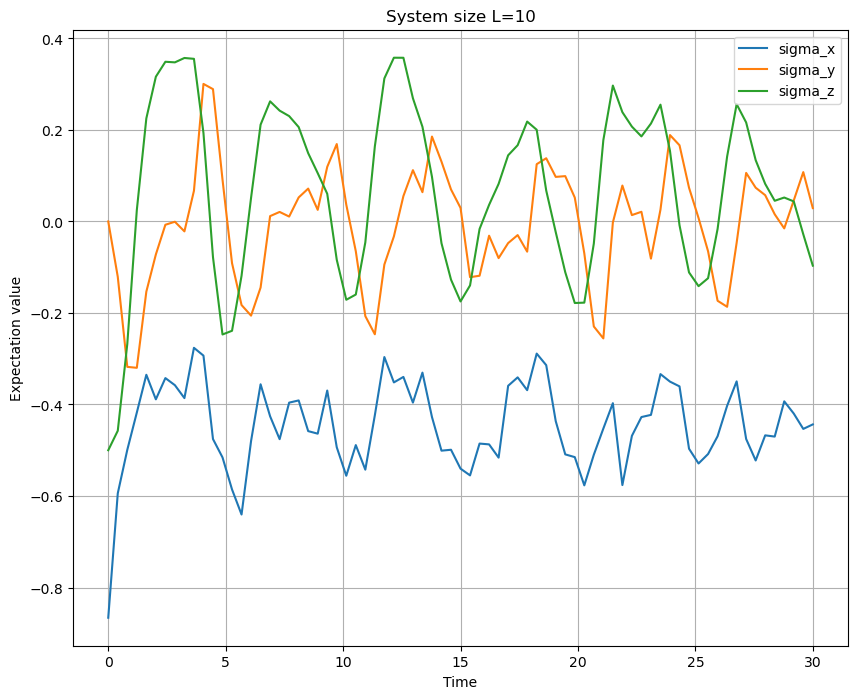

KeyboardInterrupt: 

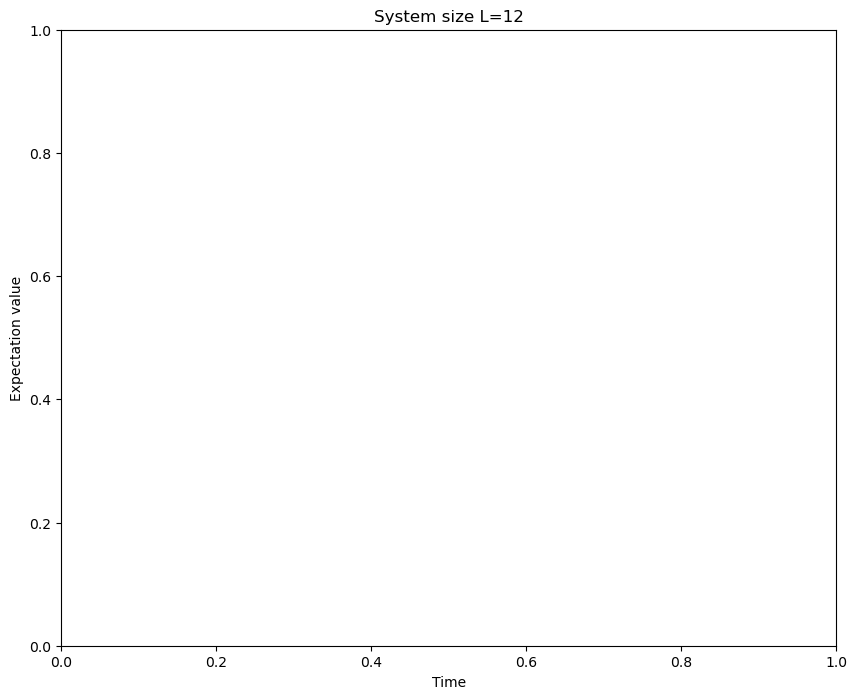

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hw3.src.p4_1.fns import compute_observable_expectation, periodic_dense_hamiltonian, make_product_state
from hw1.src.hw1 import tensor_product

# System size and parameters
L_values = [8, 10, 12]
h_x = -1.05
h_z = 0.5
t_values = np.linspace(0, 30, 75)

# Define the observables for the first site
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
identity = np.identity(2)

observables_labels = ['sigma_x', 'sigma_y', 'sigma_z']

def extend_observables(L):
    """Extend observables to the full system size."""
    full_observables = {
        'sigma_x': tensor_product([sigma_x] + [identity] * (L - 1)),
        'sigma_y': tensor_product([sigma_y] + [identity] * (L - 1)),
        'sigma_z': tensor_product([sigma_z] + [identity] * (L - 1))
    }
    return full_observables

# Ensure normalization

# Loop over different system sizes
for L in L_values:
    # Extend observables to the full system size
    full_observables = extend_observables(L)

    # Initial state: tensor product of single_site across all sites
    single_site = np.array([1, -np.sqrt(3)]) / 2
    initial_state = make_product_state(single_site, L)

    # Prepare to plot
    plt.figure(figsize=(10, 8))
    plt.title(f"System size L={L}")
    plt.xlabel("Time")
    plt.ylabel("Expectation value")

    # Generate the Hamiltonian
    H = periodic_dense_hamiltonian(L, h_x, h_z)

    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Calculate the overlap coefficients
    overlap_coefficients = np.dot(eigenvectors.conj().T, initial_state)

    for label, observable in full_observables.items():
        expectations = []
        for t in t_values:
            expectation = compute_observable_expectation(t, observable, overlap_coefficients, eigenvalues, eigenvectors)
            expectations.append(np.real(expectation))  # Using real part; adjust if needed

        plt.plot(t_values, expectations, label=label)

    plt.legend()
    plt.grid(True)
    plt.show()


I observe a dampening effect in the limit of a larger system size as time evolves. So, I would expect in the limit of an infinite system size for the expectation values to approach their equilibrium value.

4.1.2 Thermal values of observables

/Users/patrykkozlowski/anaconda3/envs/pyscf_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


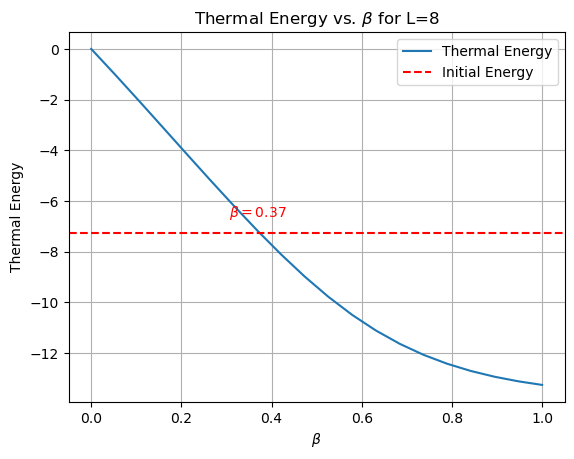

Observables at beta intersection (0.3684210526315789): {'$\\sigma_x$': -0.3293853901236412, '$\\sigma_y$': -5.087337078003373e-18j, '$\\sigma_z$': 0.33649455192006256}


/Users/patrykkozlowski/anaconda3/envs/pyscf_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


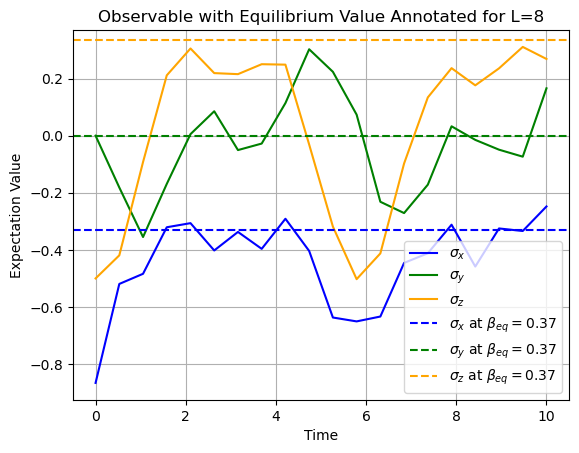

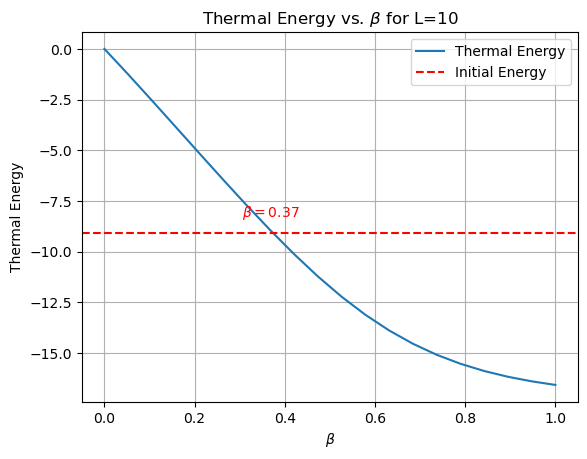

Observables at beta intersection (0.3684210526315789): {'$\\sigma_x$': -0.329402812319264, '$\\sigma_y$': 0j, '$\\sigma_z$': 0.3365559061177006}


/Users/patrykkozlowski/anaconda3/envs/pyscf_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


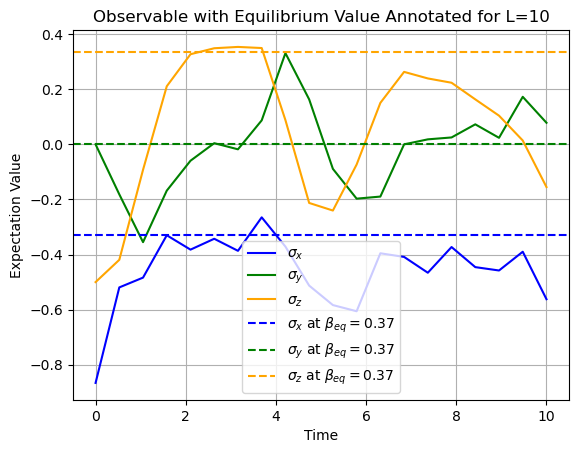

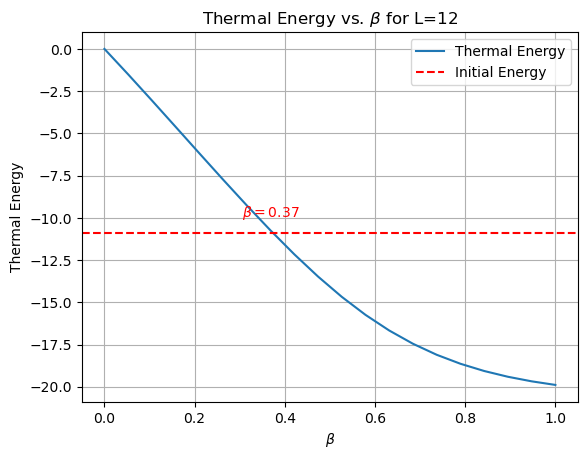

Observables at beta intersection (0.3684210526315789): {'$\\sigma_x$': -0.32940456466216433, '$\\sigma_y$': -9.61393850410832e-19j, '$\\sigma_z$': 0.3365620771879242}


/Users/patrykkozlowski/anaconda3/envs/pyscf_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


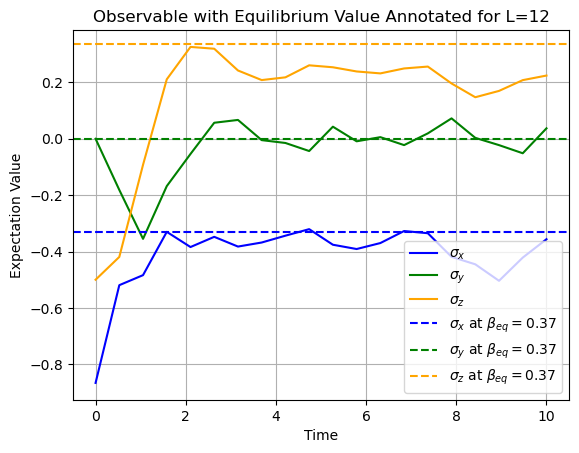

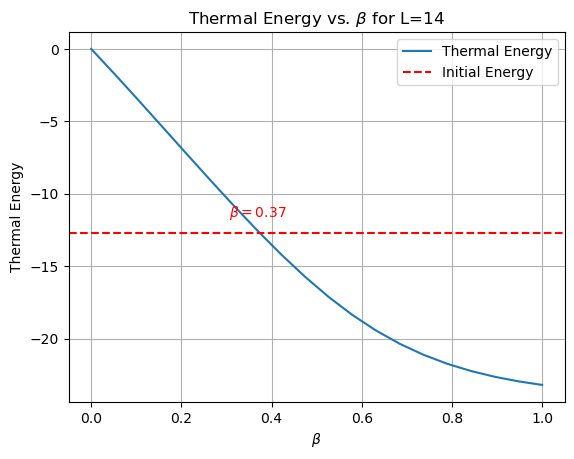

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from hw1.src.hw1 import tensor_product
from hw3.src.p4_1.fns import periodic_dense_hamiltonian, compute_observable_expectation, make_product_state, compute_thermal_energy, compute_thermal_observable
# Set system parameters
L_values = [8, 10, 12, 14]
h_x = -1.05
h_z = 0.5
beta_values = np.linspace(0, 1, 20)

# Define simple matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
identity = np.identity(2)
observables_labels = [rf"$\sigma_{label}$" for label in ['x', 'y', 'z']]
observables_colors = ['blue', 'green', 'orange']

for l in L_values:
    # Generate the Hamiltonian
    H = periodic_dense_hamiltonian(l, h_x, h_z)
    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Compute thermal energies
    thermal_energies = {}
    for beta in beta_values:
        thermal_energies[beta] = compute_thermal_energy(beta, eigenvalues)

    plt.figure()
    plt.title(f"Thermal Energy vs. $\\beta$ for L={l}")
    plt.xlabel(r"$\beta$")
    plt.ylabel("Thermal Energy")
    plt.plot(list(thermal_energies.keys()), list(thermal_energies.values()), label="Thermal Energy")
    plt.grid()

    # Generate the initial state
    single_sight = np.array([1, -np.sqrt(3)]) / 2
    initial_state = make_product_state(single_sight, l)
    
    # Calculate the overlap coefficients
    overlap_coefficients = np.dot(eigenvectors.conj().T, initial_state)

    # Compute the initial energy of the initial state
    initial_energy = compute_observable_expectation(0, H, overlap_coefficients, eigenvalues, eigenvectors)    

    # Plot the horizontal dashed red line at the initial energy
    plt.axhline(y=initial_energy, color='r', linestyle='--', label="Initial Energy")

    def find_intersection_point(thermal_energies, initial_energy):
        beta_intersection = None  # Initialize beta_intersection
        for beta, energy in thermal_energies.items():
            if abs(energy - initial_energy) < 1e0:
                plt.annotate(rf"$\beta = {beta:.2f}$", (beta, energy), textcoords="offset points", xytext=(0, 10), ha='center', color='red')
                beta_intersection = beta
                break
        return beta_intersection
    
    beta_intersection = find_intersection_point(thermal_energies, initial_energy)

    # Add legend and save the plot
    plt.legend()
    plt.show()

    # Extend observables to the full system size
    full_sigma_x = tensor_product([sigma_x] + [identity] * (l - 1))
    full_sigma_y = tensor_product([sigma_y] + [identity] * (l - 1))
    full_sigma_z = tensor_product([sigma_z] + [identity] * (l - 1))
    full_observables = [full_sigma_x, full_sigma_y, full_sigma_z]

     # Identify the value of each observable at the beta intersection if it exists
    if beta_intersection is not None:
        observables_values = {}
        for observable, label in zip(full_observables, observables_labels):
            observables_values[label] = compute_thermal_observable(beta_intersection, eigenvalues, eigenvectors, observable)
        print(f"Observables at beta intersection ({beta_intersection}): {observables_values}")
    else:
        print(f"No intersection found for L={l}")

    # Compute time-dependent values for each observable
    observables_values_time = {}
    t_values = np.linspace(0, 10, 20)
    for label, observable in zip(observables_labels, full_observables):
        expectations = []
        for t in t_values:
            expectation = compute_observable_expectation(t, observable, overlap_coefficients, eigenvalues, eigenvectors)
            expectations.append(expectation.real if np.isclose(expectation.imag, 0) else np.nan)
        observables_values_time[label] = expectations

    # Plotting section
    plt.figure()
    plt.title(f"Observable with Equilibrium Value Annotated for L={l}")
    plt.xlabel("Time")
    plt.ylabel("Expectation Value")

    # Plot each observable as a line plot
    for label, color in zip(observables_labels, observables_colors):
        plt.plot(t_values, observables_values_time[label], label=label, color=color)

    # Add a horizontal line for each observable
    for label, value, color in zip(observables_labels, observables_values.values(), observables_colors):
        plt.axhline(y=value, color=color, linestyle='--', label=rf"{label} at $\beta_{{eq}} = {beta_intersection:.2f}$")

    plt.legend()
    plt.grid()
    plt.show()

Again, as time goes on, there is an approach to the equilibrium value for the observables, which is the same phenomenon as the damping that I mentioned earlier. I notice that the $\left\langle\sigma_{1}^{y}\right\rangle_{\beta}$ observable disappears identically. This can be justified as follows:
\begin{equation}
\bra{\Psi } \sigma_{1}^{y} \ket{\Psi} = i \bra{\Psi } 
\begin{pmatrix}
0 & -1 \\
1 & 0
\end{pmatrix}
\ket{\Psi} = i \mathbb{R}
\end{equation}
so this observable has a purely imaginary expectation value, and so it shows of as a horizontal line with a value of 0 in the plot.

4.1.3 Entanglement entropy growth with time

In [ ]:
# entanglement and chippy for two systems time depended
import numpy as np
import matplotlib.pyplot as plt
from hw3.src.p4_1.fns import compute_observable_expectation, periodic_dense_hamiltonian, make_product_state, time_dependent_state
from hw2.src.p5_2 import entanglement_entropy, calculate_reduced_density_matrix

# Set system parameters
L_values = [8, 10, 12]
h_x = -1.05
h_z = 0.5
t_values = np.linspace(0, 50, 20)

for L in L_values:
    # Generate the Hamiltonian
    H = periodic_dense_hamiltonian(L, h_x, h_z)
    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Initial state: tensor product of single_site across all sites
    single_site1 = np.array([1, -np.sqrt(3)]) / 2
    initial_state1 = make_product_state(single_site1, L)
    # make a second state
    single_site2 = np.array([-2, 1]) / np.sqrt(5)
    initial_state2 = make_product_state(single_site2, L)

    # Prepare to plot
    plt.figure(figsize=(10, 8))
    plt.title(f"System size L={L}")
    plt.xlabel("Time")
    plt.ylabel("Entanglement entropy")

    # Calculate the overlap coefficients
    overlap_coefficients1 = np.dot(eigenvectors.conj().T, initial_state1)
    overlap_coefficients2 = np.dot(eigenvectors.conj().T, initial_state2)

    # initialize a list of entropy values
    entropy_values1 = []
    entropy_values2 = []

    for t in t_values:
        # Compute the time-dependent state
        state1 = time_dependent_state(t, overlap_coefficients1, eigenvalues, eigenvectors)
        state2 = time_dependent_state(t, overlap_coefficients2, eigenvalues, eigenvectors)

        # Compute the reduced density matrix
        reduced_density_matrix1 = calculate_reduced_density_matrix(state1, L, L // 2)
        reduced_density_matrix2 = calculate_reduced_density_matrix(state2, L,  L // 2)

        # Compute the entanglement entropy
        entropy1 = entanglement_entropy(reduced_density_matrix1)
        entropy2 = entanglement_entropy(reduced_density_matrix2)
        
        entropy_values1.append(entropy1)
        entropy_values2.append(entropy2)
        
    plt.plot(t_values, entropy_values1, label="Entanglement entropy for state 1")
    plt.plot(t_values, entropy_values2, label="Entanglement entropy for state 2")
    plt.legend()
    plt.grid()
    plt.savefig(f"hw3/docs/images/p4_1_3_Entanglement_Entropy_L={L}.png")


    

Since a product state is qualitatively similar to the MPS list in its ability to be decomposed into a tensor on any given site, and the product state seems to be able to represent time evolution of the entanglement entropy well, I would expect the MPS list to be able to do the same.

4.2 Eigenstate ETH

In [ ]:
# functions
import numpy as np  

def translation_operator(L):
    """Construct the translation operator T for a system of size L."""
    T = np.zeros((2 ** L, 2 ** L))

    for i in range(2 ** L):
        state = format(i, f'0{L}b')  # Binary representation of the state
        new_state = state[-1] + state[:-1]  # Shift by one site to the right
        new_index = int(new_state, 2)  # Convert back to decimal
        T[new_index, i] = 1

    return T

def identify_k0_sector(eigenvectors, T):
    """
    Identify eigenstates in the k=0 sector using the translation operator T.
    
    Parameters:
    - eigenvectors: Array of eigenvectors of the Hamiltonian.
    - T: Translation operator.
    
    Returns:
    - k0_indices: Indices of the k=0 sector eigenstates.
    """
    k0_indices = []
    for n, eigenvector in enumerate(eigenvectors.T):
        overlap = np.dot(eigenvector.conj().T, np.dot(T, eigenvector))
        if np.isclose(overlap, 1.0, atol=1e-8):
            k0_indices.append(n)
    return k0_indices

def compute_observable_expectation_eigenvalue(eigenindex, observable, eigenvalues, eigenvectors):
    """
    Compute the expectation value of an observable given the eigenindex.
    
    Parameters:
    - eigenindex: The index of the eigenvalue.
    - observable: The observable matrix.
    - eigenvalues: Eigenvalues from the Hamiltonian diagonalization.
    - eigenvectors: Eigenvectors from the Hamiltonian diagonalization.
    
    Returns:
    - expectation: The expectation value of the observable.
    """
    expectation = np.dot(eigenvectors[:, eigenindex].conj().T, np.dot(observable, eigenvectors[:, eigenindex]))
    return expectation


4.2.1: Observables in excited states


The situation is different now, because we want to consider the expectation values in the eigenstates of the Hamiltonian, not the time-evolved state.
This looks like:
\begin{equation}
\left\langle\sigma_{1}^{\mu}\right\rangle_{n}=\bra{n}\sigma_{1}^{\mu}\ket{n}
\end{equation}

/Users/patrykkozlowski/anaconda3/envs/pyscf_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/patrykkozlowski/anaconda3/envs/pyscf_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/patrykkozlowski/anaconda3/envs/pyscf_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


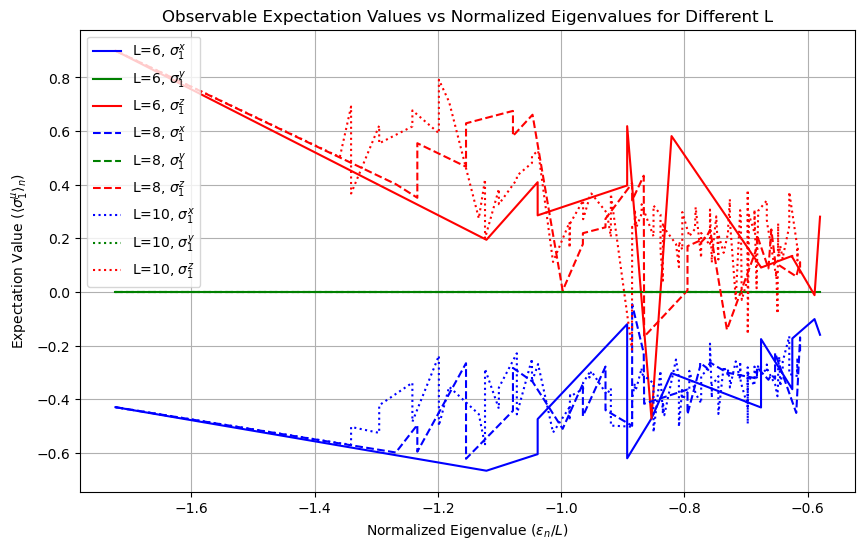

In [1]:
# observable expectation value only in 0 momentum sector
import matplotlib.pyplot as plt
import numpy as np
from hw3.src.p4_2.fns import translation_operator, identify_k0_sector, compute_observable_expectation_eigenvalue
from hw3.src.p4_1.fns import periodic_dense_hamiltonian
from hw1.src.hw1 import tensor_product

# Define line styles and colors for different system sizes and observables
line_styles = ['-', '--', ':']
colors = ['blue', 'green', 'red']  # Colors for sigma_x, sigma_y, sigma_z
observable_labels = ['x', 'y', 'z']

# System sizes
L_values = [6, 8, 10]

# Constants
h_x = -1.05
h_z = 0.5

# Prepare the plot
plt.figure(figsize=(10, 6))
plt.title('Observable Expectation Values vs Normalized Eigenvalues for Different L')
plt.xlabel(f'Normalized Eigenvalue ($\epsilon_n / L$)')
plt.ylabel(f'Expectation Value ($\langle\sigma_1^\mu\\rangle_n$)')

# Loop over system sizes
for i, L in enumerate(L_values):
    # Generate and diagonalize the Hamiltonian
    H = periodic_dense_hamiltonian(L, h_x, h_z)
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Define the translation operator for the system
    translation_op = translation_operator(L)

    # Identify the k=0 sector
    k0_sector = identify_k0_sector(eigenvectors, translation_op)

    # Define observables
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    identity = np.identity(2)
    full_observables = [tensor_product([sigma] + [identity] * (L - 1)) for sigma in [sigma_x, sigma_y, sigma_z]]

    # Compute and plot expectation values for each observable
    for j, observable in enumerate(full_observables):
        expectation_values = []
        eigenvalues_k0 = []
        for k0_index in range(len(k0_sector)):
            observable_k0 = compute_observable_expectation_eigenvalue(k0_index, observable, eigenvalues, eigenvectors)
            expectation_values.append(observable_k0)
            eigenvalues_k0.append(eigenvalues[k0_index])
        
        plt.plot(np.array(eigenvalues_k0) / L, expectation_values, label=f'L={L}, $\sigma_{{1}}^{{ {observable_labels[j]} }}$', 
                 color=colors[j], linestyle=line_styles[i])

# Add legend and show plot
plt.legend()
plt.grid(True)
plt.show()


I need to work on this response.

4.2.2 Entropic signature of thermalization

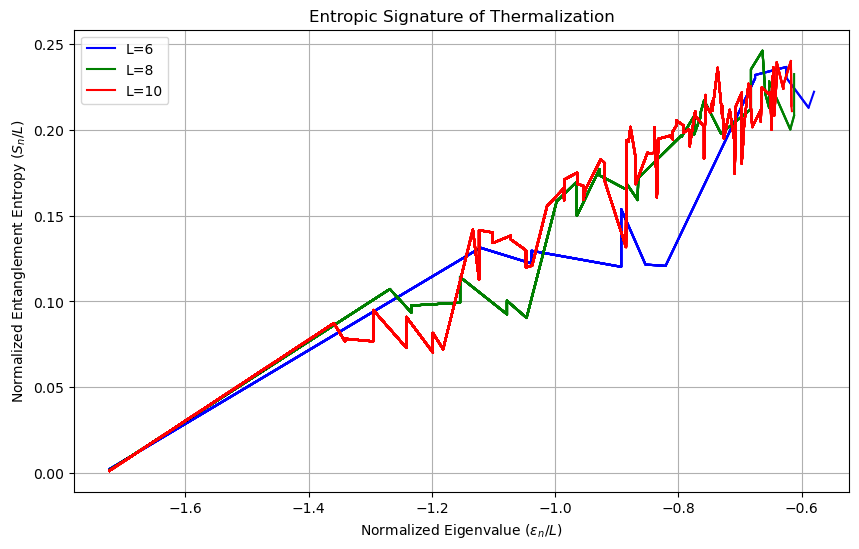

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from hw3.src.p4_2.fns import translation_operator, identify_k0_sector
from hw3.src.p4_1.fns import periodic_dense_hamiltonian
from hw1.src.hw1 import tensor_product
from hw2.src.p5_2 import entanglement_entropy, calculate_reduced_density_matrix
# Define line styles and colors for different system sizes and observables
line_styles = ['-', '--', ':']
colors = ['blue', 'green', 'red']  # Colors for sigma_x, sigma_y, sigma_z
observable_labels = ['x', 'y', 'z']

# System sizes
L_values = [6, 8, 10]

# Constants
h_x = -1.05
h_z = 0.5

# Prepare the plot
plt.figure(figsize=(10, 6))
plt.title('Entropic Signature of Thermalization')
plt.xlabel(f'Normalized Eigenvalue ($\epsilon_n / L$)')
plt.ylabel(f'Normalized Entanglement Entropy ($S_n / L$)')

# Loop over system sizes
for i, L in enumerate(L_values):
    # Generate and diagonalize the Hamiltonian
    H = periodic_dense_hamiltonian(L, h_x, h_z)
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Define the translation operator for the system
    translation_op = translation_operator(L)

    # Identify the k=0 sector
    k0_sector = identify_k0_sector(eigenvectors, translation_op)

    expectation_values = []
    eigenvalues_k0 = []
    for k0_index in range(len(k0_sector)):
        # Compute the reduced density matrix
        reduced_density_matrix = calculate_reduced_density_matrix(eigenvectors[:, k0_index], L, L // 2)
        # Compute the entanglement entropy
        entropy = entanglement_entropy(reduced_density_matrix)
        expectation_values.append(entropy)
        eigenvalues_k0.append(eigenvalues[k0_index])
        
        plt.plot(np.array(eigenvalues_k0) / L, np.array(expectation_values) / L, color=colors[i])
    # add a label for the color of the curve
    plt.plot([], [], color=colors[i], label=f'L={L}')

# Add legend and show plot
plt.legend()
plt.grid(True)
plt.show()


Response: to do.

4.3 Violations of ETH

In [ ]:
# functions
import numpy as np

def periodic_dense_hamiltonian_mbl(L, W, J=1):
    # Initialize Hamiltonian to zero matrix
    H = np.zeros((2 ** L, 2 ** L))

    # Define Pauli matrices
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    I = np.identity(2)

    # add the tensor product helper function
    def tensor_product(matrices):
        """Calculate the tensor product of a list of matrices."""
        result = matrices[0]
        for matrix in matrices[1:]:
            result = np.kron(result, matrix)
        return result
    
    # Interaction term
    for i in range(L):  # Add periodic term at the end if periodic
        matrices = [I] * L  # Start with identity matrices
        matrices[i] = sigma_z  # Apply sigma_z at position i
        matrices[(i + 1) % L] = sigma_z  # Apply sigma_z at position (i+1) modulo L for periodic
        H += -J * tensor_product(matrices)

    # transverse field term for x
    for i in range(L):
        # sample from the uniform distribution defined by (-W, W) to get an h_x value
        h_x = np.random.uniform(-W, W)
        matrices = [I] * L
        matrices[i] = sigma_x
        H += -h_x * tensor_product(matrices)

    # transverse field term for z
    for i in range(L):
        # sample from the uniform distribution defined by (-W, W) to get an h_z value
        h_z = np.random.uniform(-W, W)
        matrices = [I] * L
        matrices[i] = sigma_z
        H += -h_z * tensor_product(matrices)

    return H

4.3.1 Many-body localized model

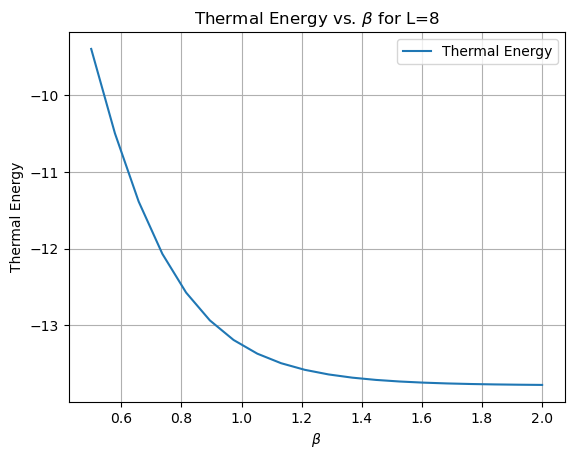

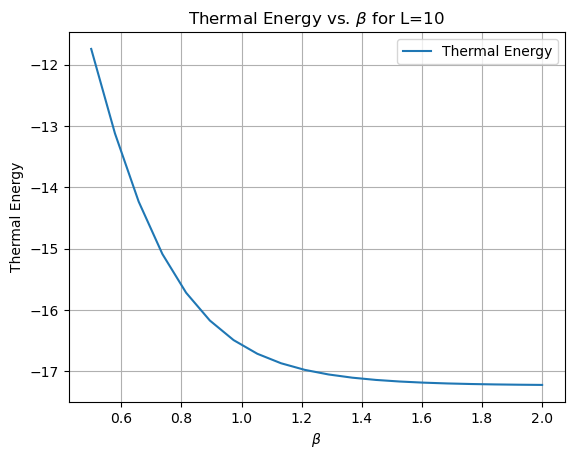

In [ ]:
# time evolution of observables with annotation
import numpy as np
import matplotlib.pyplot as plt
from hw1.src.hw1 import tensor_product
from hw3.src.p4_1.fns import compute_observable_expectation, make_product_state, compute_thermal_energy, compute_thermal_observable
from hw3.src.p4_3.fns import periodic_dense_hamiltonian_mbl

# Set system parameters
L_values = [8, 10, 12]
W = 3
beta_values = np.linspace(-0.5, 0.5, 20)

# Define simple matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
identity = np.identity(2)
observables_labels = [rf"$\sigma_{label}$" for label in ['x', 'y', 'z']]
observables_colors = ['blue', 'green', 'orange']

for l in L_values:
    # Generate the Hamiltonian
    H = periodic_dense_hamiltonian_mbl(l, W)
    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Compute thermal energies
    thermal_energies = {}
    for beta in beta_values:
        thermal_energies[beta] = compute_thermal_energy(beta, eigenvalues)

    plt.figure()
    plt.title(f"Thermal Energy vs. $\\beta$ for L={l}")
    plt.xlabel(r"$\beta$")
    plt.ylabel("Thermal Energy")
    plt.plot(list(thermal_energies.keys()), list(thermal_energies.values()), label="Thermal Energy")
    plt.grid()

    # Generate the initial state
    single_sight = np.array([1, -np.sqrt(3)]) / 2
    initial_state = make_product_state(single_sight, l)
    
    # Calculate the overlap coefficients
    overlap_coefficients = np.dot(eigenvectors.conj().T, initial_state)

    # Compute the initial energy of the initial state
    initial_energy = compute_observable_expectation(0, H, overlap_coefficients, eigenvalues, eigenvectors)    

    # Plot the horizontal dashed red line at the initial energy
    plt.axhline(y=initial_energy, color='r', linestyle='--', label="Initial Energy")

    # Prepare data for interpolation
    betas = list(thermal_energies.keys())
    energies = list(thermal_energies.values())

    # Ensure data is sorted by energy since np.interp requires the 'xp' array to be increasing
    sorted_indices = np.argsort(energies)
    sorted_energies = np.array(energies)[sorted_indices]
    sorted_betas = np.array(betas)[sorted_indices]

    # Interpolating to find intersection point
    beta_intersection = np.interp(initial_energy, sorted_energies, sorted_betas)


    # Plot and annotate intersection point
    plt.plot(beta_intersection, initial_energy, 'ro')
    plt.annotate(rf"$\beta = {beta_intersection:.2f}$", (beta_intersection, initial_energy), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    # Add legend and save the plot
    plt.legend()
    plt.savefig(f"hw3/docs/images/p4_3_1_thermal_energy_L{l}.png")

    # Extend observables to the full system size
    full_sigma_x = tensor_product([sigma_x] + [identity] * (l - 1))
    full_sigma_y = tensor_product([sigma_y] + [identity] * (l - 1))
    full_sigma_z = tensor_product([sigma_z] + [identity] * (l - 1))
    full_observables = [full_sigma_x, full_sigma_y, full_sigma_z]

    # Compute time-dependent values for each observable
    observables_values_time = {}
    t_values = np.linspace(0, 10, 20)
    for label, observable in zip(observables_labels, full_observables):
        expectations = []
        for t in t_values:
            expectation = compute_observable_expectation(t, observable, overlap_coefficients, eigenvalues, eigenvectors)
            expectations.append(expectation.real if np.isclose(expectation.imag, 0) else np.nan)
        observables_values_time[label] = expectations

    # Plotting section
    plt.figure()
    plt.title(f"Observable with Equilibrium Value Annotated for L={l}")
    plt.xlabel("Time")
    plt.ylabel("Expectation Value")

    # Plot each observable as a line plot
    for label, color in zip(observables_labels, observables_colors):
        plt.plot(t_values, observables_values_time[label], label=label, color=color)

    # Add a horizontal line for each observable
    for label, value, color in zip(observables_labels, observables_values.values(), observables_colors):
        plt.axhline(y=value, color=color, linestyle='--', label=rf"{label} at $\beta_{{eq}} = {beta_intersection:.2f}$")

    plt.legend()
    plt.grid()
    plt.show()